# oversampling
* 기존변수 + u-g,g-r,r-i,i-z만 추가변수로 사용
* fiber_ID를 제외하고 진행해봄
* 제출결과 : 0.486204666(lr=0.05)/0.4869218777(lr=0.01)
-> oversample 모양은 이쁘나 생각보다별로 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [40]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [42]:
train_df.type.unique()

array(['QSO', 'STAR_RED_DWARF', 'SERENDIPITY_BLUE', 'STAR_BHB',
       'STAR_CATY_VAR', 'SERENDIPITY_DISTANT', 'GALAXY',
       'SPECTROPHOTO_STD', 'REDDEN_STD', 'ROSAT_D', 'STAR_WHITE_DWARF',
       'SERENDIPITY_RED', 'STAR_CARBON', 'SERENDIPITY_FIRST',
       'STAR_BROWN_DWARF', 'STAR_SUB_DWARF', 'SKY', 'SERENDIPITY_MANUAL',
       'STAR_PN'], dtype=object)

In [41]:
train_df.type.value_counts()

QSO                    49680
GALAXY                 37347
SERENDIPITY_BLUE       21760
SPECTROPHOTO_STD       14630
REDDEN_STD             14618
STAR_RED_DWARF         13750
STAR_BHB               13500
SERENDIPITY_FIRST       7132
ROSAT_D                 6580
STAR_CATY_VAR           6506
SERENDIPITY_DISTANT     4654
STAR_CARBON             3257
SERENDIPITY_RED         2562
STAR_WHITE_DWARF        2160
STAR_SUB_DWARF          1154
STAR_BROWN_DWARF         500
SKY                      127
SERENDIPITY_MANUAL        61
STAR_PN                   13
Name: type, dtype: int64

### oversampling

In [49]:
import imblearn

In [47]:
imblearn.__version__

'0.6.2'

In [ ]:
imblearn.over_sampling.SMOTE()

In [5]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

y = train_df.type
X = train_df.drop('type',axis = 1)

train_df.shape

Using TensorFlow backend.
C:\Users\starl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\starl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\starl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\starl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

(199991, 22)

In [6]:
resample_X, resample_y = sm.fit_resample(X,y)

In [7]:
resample_X.shape

(943920, 21)

In [8]:
new_train = pd.concat([resample_X,resample_y],axis = 1)
new_train = new_train[train_df.columns]

## DATA Setting

In [9]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

new_train['type_num'] = new_train['type'].apply(lambda x: to_number(x, column_number))


In [10]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [11]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [12]:
train_df = add_minus_feature_all(new_train)
test_df = add_minus_feature_all(test_df,True)

In [13]:
train_df.shape,test_df.shape

((943920, 63), (10009, 61))

In [14]:
train_df.columns

Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'type_num', 'psfMag_u-g', 'psfMag_u-r', 'psfMag_u-i',
       'psfMag_u-z', 'psfMag_g-r', 'psfMag_g-i', 'psfMag_g-z', 'psfMag_r-i',
       'psfMag_r-z', 'psfMag_i-z', 'fiberMag_u-g', 'fiberMag_u-r',
       'fiberMag_u-i', 'fiberMag_u-z', 'fiberMag_g-r', 'fiberMag_g-i',
       'fiberMag_g-z', 'fiberMag_r-i', 'fiberMag_r-z', 'fiberMag_i-z',
       'petroMag_u-g', 'petroMag_u-r', 'petroMag_u-i', 'petroMag_u-z',
       'petroMag_g-r', 'petroMag_g-i', 'petroMag_g-z', 'petroMag_r-i',
       'petroMag_r-z', 'petroMag_i-z', 'modelMag_u-g', 'modelMag_u-r',
       'modelMag_u-i', 'modelMag_u-z', 'modelMag_g-r', 'modelMag_g-i',
       'modelMag_g-z', 'modelMag_r-i', 'modelMag_r-z

In [45]:
train_df.describe()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,360.830152,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,225.305890,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,1.000000,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,174.000000,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,349.000000,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,526.000000,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1000.000000,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [43]:
train_X.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,...,petroMag_g-i,petroMag_g-z,petroMag_r-i,petroMag_r-z,petroMag_i-z,modelMag_u-g,modelMag_u-r,modelMag_u-i,modelMag_u-z,modelMag_g-r,modelMag_g-i,modelMag_g-z,modelMag_r-i,modelMag_r-z,modelMag_i-z
count,9.439200e+05,943920.000000,943920.000000,943920.000000,943920.000000,9.439200e+05,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,...,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000,943920.000000
mean,1.516299e+01,19.715893,19.210102,18.483440,18.104995,1.920910e+01,20.125085,19.880817,18.878990,18.455486,21.392724,19.838692,19.408367,18.428738,18.008949,...,1.409954,1.829744,0.979629,1.399418,0.419790,1.392331,2.175964,2.752228,3.342950,0.783633,1.359897,1.950619,0.576264,1.166985,0.590722
std,5.467412e+03,114.291511,85.016918,84.665961,77.077800,1.921244e+03,350.308810,53.581318,75.582045,89.589845,408.084888,96.907781,58.347338,94.854140,86.604463,...,109.787792,101.192525,82.274252,81.334771,99.300963,110.784477,112.027558,85.922763,86.093033,123.695445,95.988104,112.253992,114.566539,80.954073,89.545278
min,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,...,-22891.551474,-43362.541587,-17774.817548,-28762.699736,-28769.229808,-19285.472906,-26744.835985,-29355.852232,-18568.166776,-34159.490689,-27517.533434,-25982.821480,-30088.904996,-20197.579053,-43030.699316
25%,1.978292e+01,19.015381,18.203447,17.766365,17.295130,2.006844e+01,19.263906,18.461998,18.051304,17.593621,19.573289,18.677948,17.975575,17.529326,17.082171,...,0.204263,0.340030,0.017378,0.101379,0.017421,0.339446,0.653540,0.754921,0.904556,0.167494,0.228026,0.332064,0.031736,0.104412,0.020849
50%,2.131864e+01,20.079570,19.558872,19.260365,18.581436,2.151581e+01,20.330866,19.807873,19.525583,18.855333,20.875970,19.995054,19.441332,19.062510,18.396784,...,0.943440,1.333458,0.333882,0.612486,0.277281,1.015895,1.451752,1.951555,2.213578,0.571858,0.949944,1.264566,0.340814,0.592190,0.276091
75%,2.338145e+01,22.055640,20.841357,20.146703,19.730173,2.347245e+01,22.242289,21.032632,20.364576,19.894171,22.802029,21.726950,20.623274,20.024597,19.530214,...,2.713641,3.457984,1.227953,1.986205,0.789287,1.955620,3.265417,4.528261,5.474850,1.451483,2.720913,3.380884,1.214614,1.883603,0.721030
max,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,...,48327.581323,21243.739746,45303.415779,27912.630495,32930.315367,45115.192779,37605.483750,24462.532540,32530.733705,38497.083482,30336.928723,30770.030971,51207.368525,20525.345144,20524.686627


In [15]:
train_X = train_df.drop(columns=['type', 'type_num','fiberID'], axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns = ['fiberID'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [17]:
train_ds = lgb.Dataset(X_train, label = y_train)
test_ds = lgb.Dataset(X_test, label = y_test) 

In [18]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.01,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [19]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 1000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 1.08298	Test's multi_logloss: 1.08855
[200]	Train's multi_logloss: 0.663933	Test's multi_logloss: 0.671506
[300]	Train's multi_logloss: 0.493399	Test's multi_logloss: 0.502926
[400]	Train's multi_logloss: 0.413378	Test's multi_logloss: 0.424584
[500]	Train's multi_logloss: 0.369751	Test's multi_logloss: 0.382635
[600]	Train's multi_logloss: 0.343037	Test's multi_logloss: 0.357712
[700]	Train's multi_logloss: 0.324593	Test's multi_logloss: 0.341329
[800]	Train's multi_logloss: 0.310996	Test's multi_logloss: 0.329606
[900]	Train's multi_logloss: 0.300248	Test's multi_logloss: 0.320654
[1000]	Train's multi_logloss: 0.291357	Test's multi_logloss: 0.313612
Did not meet early stopping. Best iteration is:
[1000]	Train's multi_logloss: 0.291357	Test's multi_logloss: 0.313612


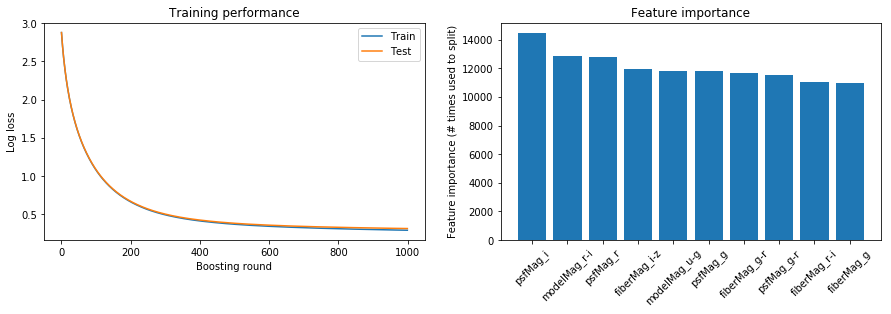

In [20]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [21]:
train_y_pred = lgmb_model.predict(X_test)
real_y_pred = lgmb_model.predict(test_X)

In [22]:
train_y_pred.shape

(283176, 19)

In [23]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.3136124076557462

In [24]:
lgmb_model.feature_importance()

array([ 7069, 11826, 12815, 14462,  9652,  6286, 11007,  7633,  8651,
        6217,  8253,  6641,  7332,  7733,  6632,  7130,  7150,  6169,
        6108,  9321, 10763,  6803,  3738,  2710, 11564,  5362,  4325,
        9672,  5858, 10297, 10750,  6599,  2656,  3884, 11655,  5793,
        3999, 11064,  9730, 11974, 10407,  6372,  3148,  4463, 10399,
        4449,  4089,  8478,  5004,  7360, 11828,  6115,  2591,  2808,
       10515,  5833,  3937, 12836,  7344, 10741])

### feature_importance

In [25]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

,importance
psfMag_i,14462
modelMag_r-i,12836
psfMag_r,12815
fiberMag_i-z,11974
modelMag_u-g,11828
psfMag_g,11826
fiberMag_g-r,11655
psfMag_g-r,11564
fiberMag_r-i,11064
fiberMag_g,11007


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0(STAR_WHITE_DWARF-2160),2(STAR_BROWN_DWARF-500),7(SERENDIPITY_DISTANT-4654),11(ROSAT_D-6580)
망한예측 : 12(STAR_PN-13),17(SERENDIPITY_MANUAL-61)

In [26]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [27]:
number_columns

{0: 'STAR_WHITE_DWARF',
 1: 'STAR_CATY_VAR',
 2: 'STAR_BROWN_DWARF',
 3: 'SERENDIPITY_RED',
 4: 'REDDEN_STD',
 5: 'STAR_BHB',
 6: 'GALAXY',
 7: 'SERENDIPITY_DISTANT',
 8: 'QSO',
 9: 'SKY',
 10: 'STAR_RED_DWARF',
 11: 'ROSAT_D',
 12: 'STAR_PN',
 13: 'SERENDIPITY_FIRST',
 14: 'STAR_CARBON',
 15: 'SPECTROPHOTO_STD',
 16: 'STAR_SUB_DWARF',
 17: 'SERENDIPITY_MANUAL',
 18: 'SERENDIPITY_BLUE'}

In [28]:
train_df.type.value_counts()

GALAXY                 49680
SERENDIPITY_BLUE       49680
STAR_CATY_VAR          49680
STAR_PN                49680
REDDEN_STD             49680
SERENDIPITY_FIRST      49680
STAR_BHB               49680
QSO                    49680
SERENDIPITY_MANUAL     49680
STAR_RED_DWARF         49680
STAR_WHITE_DWARF       49680
SKY                    49680
STAR_BROWN_DWARF       49680
SPECTROPHOTO_STD       49680
STAR_CARBON            49680
ROSAT_D                49680
SERENDIPITY_RED        49680
SERENDIPITY_DISTANT    49680
STAR_SUB_DWARF         49680
Name: type, dtype: int64

In [29]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,12956,0,0,0,180,243,3,584,49,0,0,292,4,8,340,58,0,14,173
1,42,14467,0,0,0,0,0,3,67,0,2,22,0,13,0,0,15,7,266
2,0,0,14483,319,0,0,0,0,0,0,72,0,0,0,0,0,0,30,0
3,1,0,791,13952,0,0,0,0,0,0,118,5,0,5,0,0,0,32,0
4,23,0,0,0,14634,64,1,0,4,0,0,42,0,0,0,136,0,0,0
5,301,0,0,0,266,13551,0,591,17,0,0,24,0,2,0,144,0,3,5
6,12,20,0,1,10,9,14270,1,32,0,1,217,0,275,26,6,0,22,2
7,3016,0,0,0,0,500,0,10923,81,0,1,24,12,8,0,1,1,26,311
8,240,17,2,2,26,248,101,70,11340,4,6,742,5,629,107,7,12,55,1291
9,0,0,0,0,0,0,0,0,0,14904,0,0,0,0,0,0,0,0,0


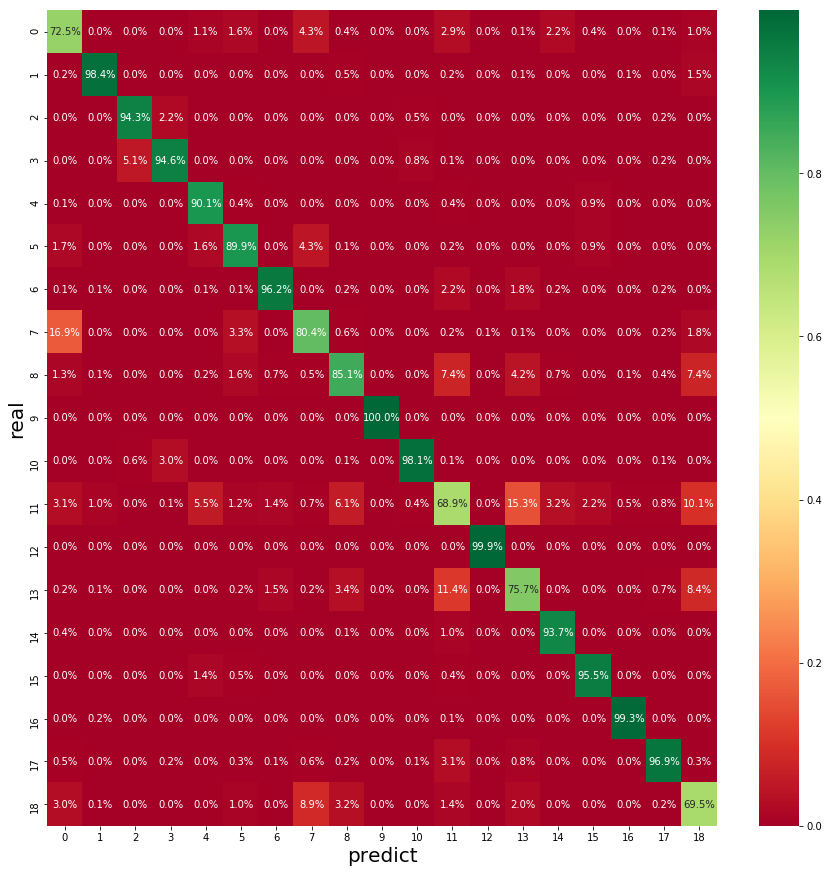

In [30]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [31]:
train_ds = lgb.Dataset(train_X, label = train_y)

In [32]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 1000, 
                       valid_sets = [train_ds], valid_names=['Train'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 1.08514
[200]	Train's multi_logloss: 0.665941
[300]	Train's multi_logloss: 0.495724
[400]	Train's multi_logloss: 0.416135
[500]	Train's multi_logloss: 0.373013
[600]	Train's multi_logloss: 0.346518
[700]	Train's multi_logloss: 0.328567
[800]	Train's multi_logloss: 0.315085
[900]	Train's multi_logloss: 0.304624
[1000]	Train's multi_logloss: 0.296026
Did not meet early stopping. Best iteration is:
[1000]	Train's multi_logloss: 0.296026


In [33]:
# lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, verbose_eval=100)

In [34]:
y_pred = lgmb_model.predict(test_X)

In [35]:
y_pred

array([[2.39841378e-04, 2.14380192e-04, 1.32347485e-02, ...,
        1.84972529e-04, 6.75245120e-02, 2.42165849e-04],
       [3.34013330e-04, 2.62384541e-04, 2.36344785e-04, ...,
        2.38938822e-04, 8.62050953e-03, 3.53207233e-04],
       [5.87414837e-04, 1.69355836e-04, 7.98995811e-05, ...,
        7.98453319e-05, 8.58054931e-03, 1.00199364e-04],
       ...,
       [1.09290093e-03, 8.39319007e-04, 3.86462679e-04, ...,
        3.86200284e-04, 8.54559495e-03, 7.14671716e-02],
       [6.24413825e-05, 4.78213100e-05, 4.30753930e-05, ...,
        4.30461462e-05, 6.44881344e-04, 1.06877667e-03],
       [7.87875933e-04, 1.98106930e-05, 1.74865668e-05, ...,
        1.74746940e-05, 8.05759603e-05, 6.42852670e-05]])

In [36]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)